# N:2 MENT — integration-based solver

In [1]:
import os
import sys
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import ultraplot as plt
from ipywidgets import interact
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import ment
from ment.sim import simulate
from ment.train.plot import PlotDistCorner
from ment.train.plot import PlotProj2D_Contour
from ment.utils import unravel

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

## Source distribution

In [3]:
dist_name = "gaussian_mixture"
ndim = 4
xmax = 3.5
seed = 12345

In [4]:
dist = ment.dist.get_dist(dist_name, ndim=ndim, seed=seed)
x_true = dist.sample(1_000_000)

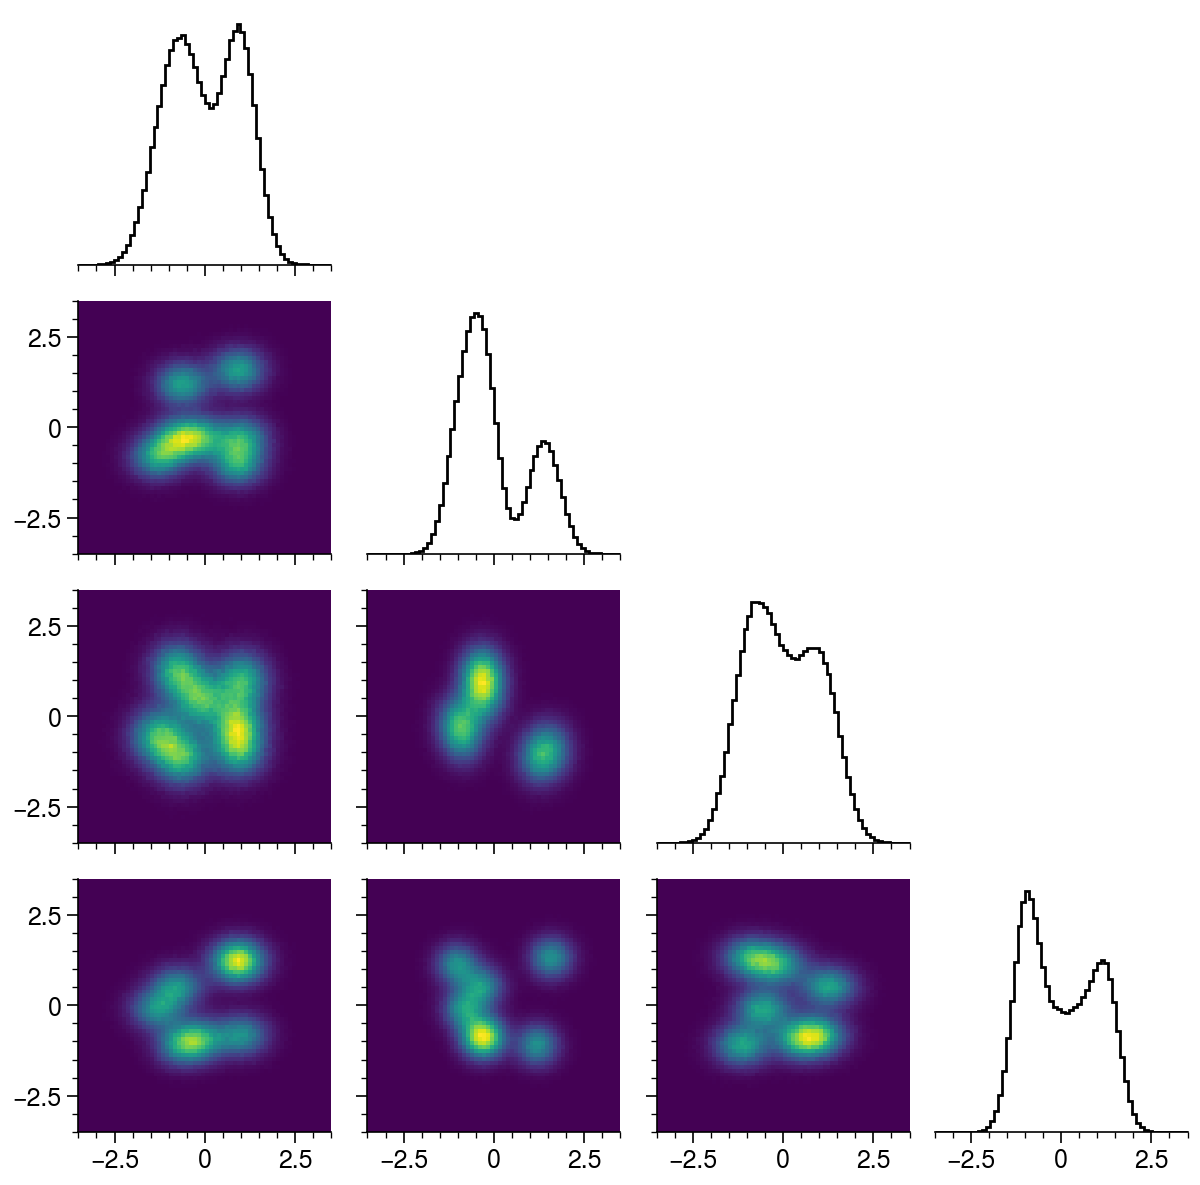

In [5]:
limits = ndim * [(-xmax, xmax)]

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.5))
grid.plot_points(x_true, limits=limits, bins=64, mask=False)
plt.show()

## Data generation

In [6]:
nmeas = ndim * (ndim - 1) // 2
nbins = 64
blur = 1.0
kde = False
kde_bandwidth_frac = 1.0
axis_meas = (0, 2)

In [7]:
# Create transforms (permutation matrices)
transfer_matrices = []
for i in range(ndim):
    for j in range(i):
        matrices = []
        for k, l in zip(axis_meas, (j, i)):
            matrix = np.identity(ndim)
            matrix[k, k] = matrix[l, l] = 0.0
            matrix[k, l] = matrix[l, k] = 1.0
            matrices.append(matrix)
        transfer_matrices.append(np.linalg.multi_dot(matrices[::-1]))

transforms = []
for matrix in transfer_matrices:
    transform = ment.sim.LinearTransform(matrix)
    transforms.append(transform)

# Create histogram diagnostics
axis_proj = axis_meas
bin_edges = 2 * [np.linspace(-xmax, xmax, nbins + 1)]

projections = []
for transform in transforms:
    projection = ment.diag.HistogramND(
        axis=axis_meas,
        edges=bin_edges,
        kde=kde,
        kde_bandwidth_frac=kde_bandwidth_frac,
        blur=blur,
        thresh=0.0,
        thresh_type="abs",
    )
    projections.append([projection])

# Generate data
projections = ment.sim.simulate_with_diag_update(
    x_true,
    transforms,
    projections,
    kde=False,
    blur=False,
    thresh=5.00e-03,
)

In [8]:
integration_limits = [limits[i] for i in range(ndim) if i not in axis_proj]
integration_limits = [[integration_limits]] * len(transforms)

In [9]:
# @interact(index=(0, nmeas - 1))
# def update(index: int):
#     coords = unravel(projections)[index].coords
#     values = unravel(projections)[index].values

#     fig, ax = plt.subplots()
#     ax.pcolormesh(coords[0], coords[1], values.T, colorbar=True,)

## Model

In [10]:
sampler = "mcmc"
nsamp = 1_000_000
burnin = 500
chains = 1000
c = 2.4 / np.sqrt(ndim)

if sampler == "grid":
    samp_grid_res = 32
    samp_noise = 0.5
    samp_grid_shape = ndim * [samp_grid_res]
    samp_grid_limits = limits

    sampler = ment.samp.GridSampler(
        grid_limits=samp_grid_limits,
        grid_shape=samp_grid_shape,
        noise=samp_noise,
    )
elif sampler == "mcmc":
    proposal_cov = 0.1 * np.eye(ndim)

    start = np.random.multivariate_normal(np.zeros(ndim), 0.5 * np.eye(ndim), size=chains)

    sampler = ment.samp.MetropolisHastingsSampler(
        ndim=ndim,
        chains=chains,
        proposal_cov=proposal_cov,
        start=start,
        burnin=burnin,
        shuffle=True,
        verbose=True,
    )
else:
    raise ValueError

In [11]:
prior = ment.GaussianPrior(ndim=ndim, scale=1.0)

model = ment.MENT(
    ndim=ndim,
    transforms=transforms,
    projections=projections,
    prior=prior,
    interpolation_kws=dict(method="linear"),
    sampler=sampler,
    nsamp=nsamp,
    integration_limits=integration_limits,
    integration_size=(10**4),
    store_integration_points=True,
    mode="integrate",
    verbose=0,
)

## Train

In [12]:
plot_nsamp = 1_000_000

In [13]:
def plot_model(model):
    figs = []

    # Sample particles
    x_pred = model.sample(plot_nsamp)

    # Plot reconstructed vs. true distribution
    grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.25), diag_shrink=0.80)
    grid.plot_points(
        x_pred,
        limits=limits,
        bins=65,
        mask=False,
        cmap="viridis",
    )
    figs.append(grid.fig)

    # Simulate measurements
    projections_true = ment.sim.copy_histograms(model.projections)
    projections_pred = ment.sim.copy_histograms(model.diagnostics)
    projections_pred = ment.sim.simulate_with_diag_update(
        x_pred, transforms, projections_pred, kde=False, blur=False
    )

    projections_true = unravel(projections_true)
    projections_pred = unravel(projections_pred)

    # Plot simulated vs. measured projections.
    contour_levels = np.linspace(0.01, 1.0, 7)
    contour_colors = ["black", "red"]
    plot_kws = dict(
        process_kws=dict(blur=1.0, scale="max"),
        kind="contour",
        levels=contour_levels,
        lw=0.9,
    )

    ncols = min(nmeas, 7)
    nrows = int(np.ceil(nmeas / ncols))
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figwidth=(1.1 * ncols))
    for proj_true, proj_pred, ax in zip(projections_true, projections_pred, axs):
        psv.plot_hist(proj_true, ax=ax, colors=contour_colors[0], **plot_kws)
        psv.plot_hist(proj_pred, ax=ax, colors=contour_colors[1], **plot_kws)
    figs.append(fig)

    return figs

non numeric history values being saved


  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

 11%|███████████▉                                                                                                   | 161/1499 [00:00<00:00, 1608.20it/s]

 22%|████████████████████████▏                                                                                      | 326/1499 [00:00<00:00, 1629.80it/s]

 33%|████████████████████████████████████▎                                                                          | 490/1499 [00:00<00:00, 1630.12it/s]

 44%|████████████████████████████████████████████████▌                                                              | 656/1499 [00:00<00:00, 1638.46it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 821/1499 [00:00<00:00, 1641.15it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 986/1499 [00:00<00:00, 1643.42it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▍                         | 1151/1499 [00:00<00:00, 1643.38it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1316/1499 [00:00<00:00, 1643.79it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1481/1499 [00:00<00:00, 1644.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:00<00:00, 1638.92it/s]

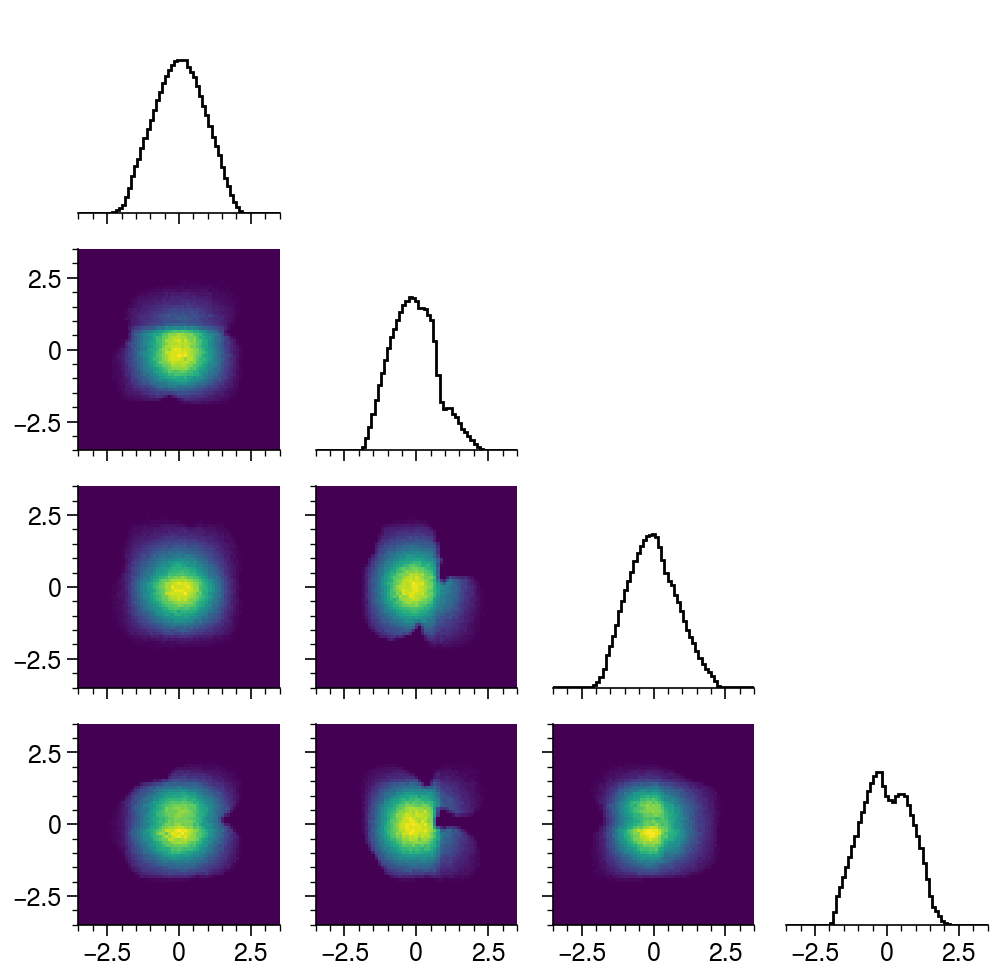

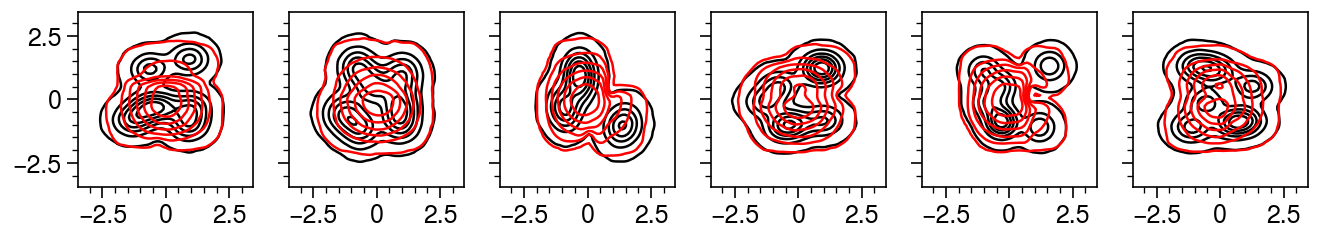

None
epoch = 1


  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

 11%|███████████▉                                                                                                   | 162/1499 [00:00<00:00, 1617.06it/s]

 22%|████████████████████████▏                                                                                      | 326/1499 [00:00<00:00, 1628.89it/s]

 33%|████████████████████████████████████▎                                                                          | 491/1499 [00:00<00:00, 1636.47it/s]

 44%|████████████████████████████████████████████████▌                                                              | 656/1499 [00:00<00:00, 1641.61it/s]

 55%|████████████████████████████████████████████████████████████▊                                                  | 821/1499 [00:00<00:00, 1641.47it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 986/1499 [00:00<00:00, 1643.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▍                         | 1151/1499 [00:00<00:00, 1643.19it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1316/1499 [00:00<00:00, 1639.45it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1481/1499 [00:00<00:00, 1641.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:00<00:00, 1638.43it/s]

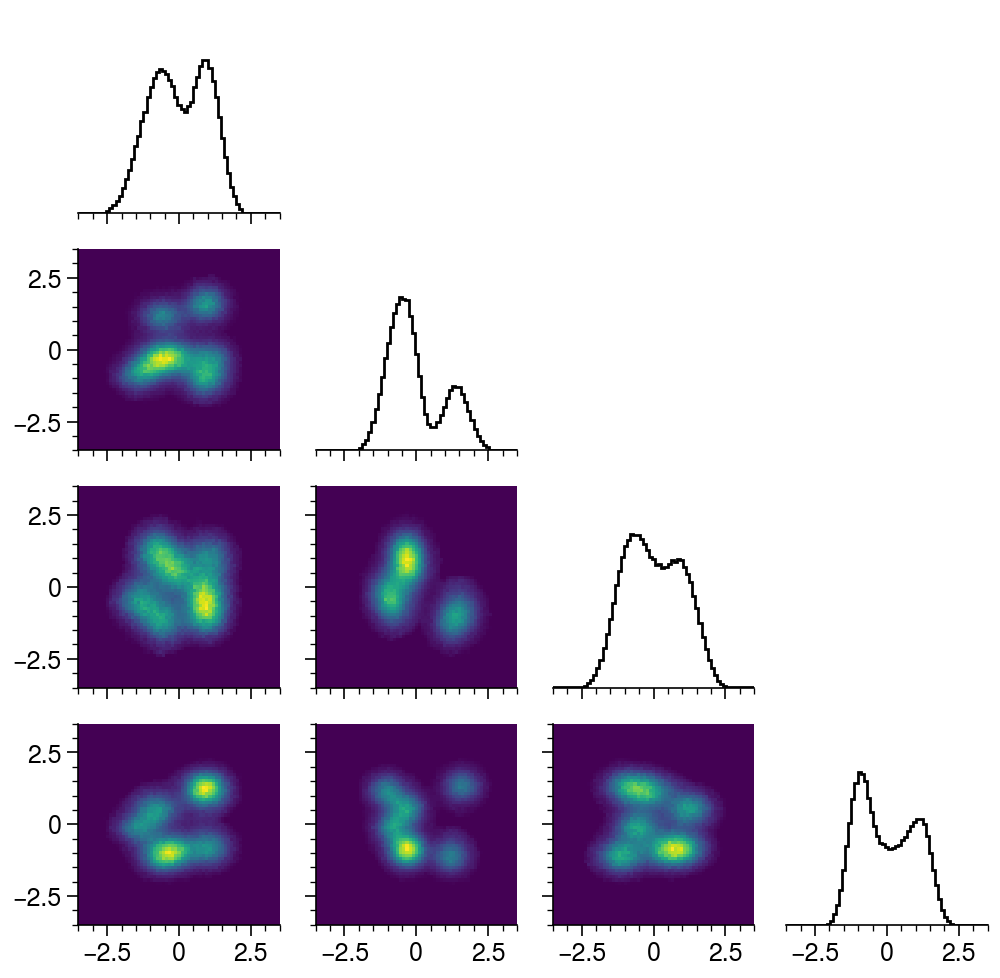

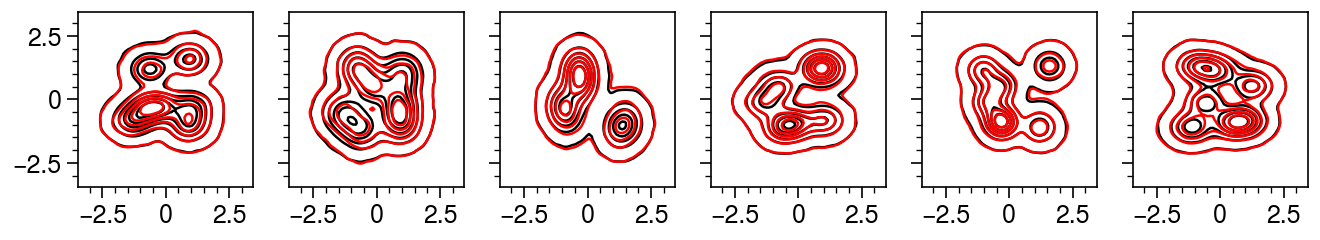

None
epoch = 2


  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

 11%|████████████                                                                                                   | 163/1499 [00:00<00:00, 1623.62it/s]

 22%|████████████████████████▏                                                                                      | 326/1499 [00:00<00:00, 1615.37it/s]

 33%|████████████████████████████████████▎                                                                          | 490/1499 [00:00<00:00, 1625.97it/s]

 44%|████████████████████████████████████████████████▍                                                              | 654/1499 [00:00<00:00, 1629.78it/s]

 55%|████████████████████████████████████████████████████████████▌                                                  | 818/1499 [00:00<00:00, 1630.74it/s]

 66%|████████████████████████████████████████████████████████████████████████▋                                      | 982/1499 [00:00<00:00, 1629.65it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                          | 1146/1499 [00:00<00:00, 1630.45it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1310/1499 [00:00<00:00, 1631.28it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1474/1499 [00:00<00:00, 1632.37it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:00<00:00, 1628.24it/s]

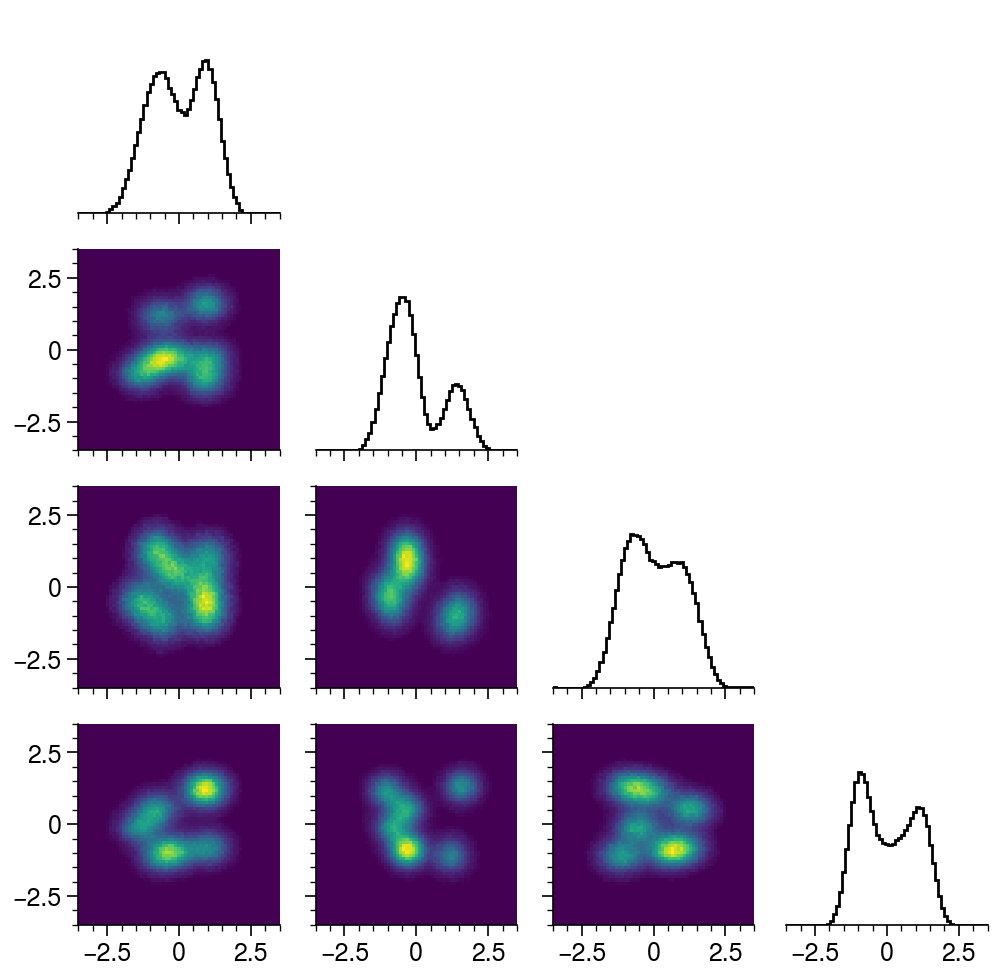

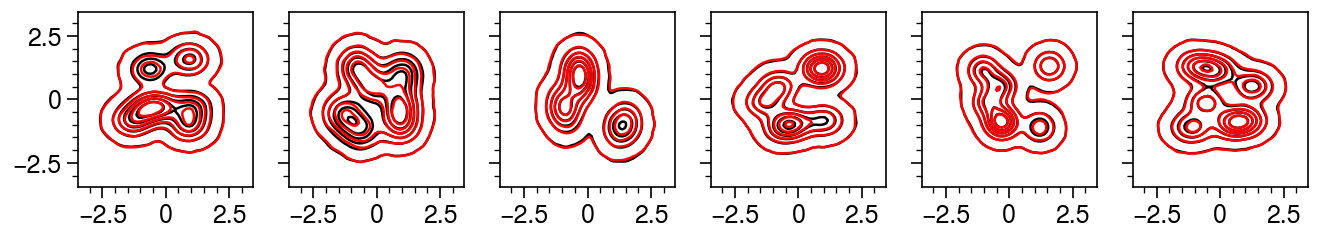

None
epoch = 3


  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

 11%|████████████                                                                                                   | 163/1499 [00:00<00:00, 1625.11it/s]

 22%|████████████████████████▏                                                                                      | 327/1499 [00:00<00:00, 1628.00it/s]

 33%|████████████████████████████████████▎                                                                          | 491/1499 [00:00<00:00, 1631.02it/s]

 44%|████████████████████████████████████████████████▌                                                              | 656/1499 [00:00<00:00, 1634.59it/s]

 55%|████████████████████████████████████████████████████████████▋                                                  | 820/1499 [00:00<00:00, 1618.04it/s]

 66%|████████████████████████████████████████████████████████████████████████▋                                      | 982/1499 [00:00<00:00, 1613.45it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████                          | 1145/1499 [00:00<00:00, 1618.49it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████              | 1309/1499 [00:00<00:00, 1625.29it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1473/1499 [00:00<00:00, 1627.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:00<00:00, 1623.94it/s]

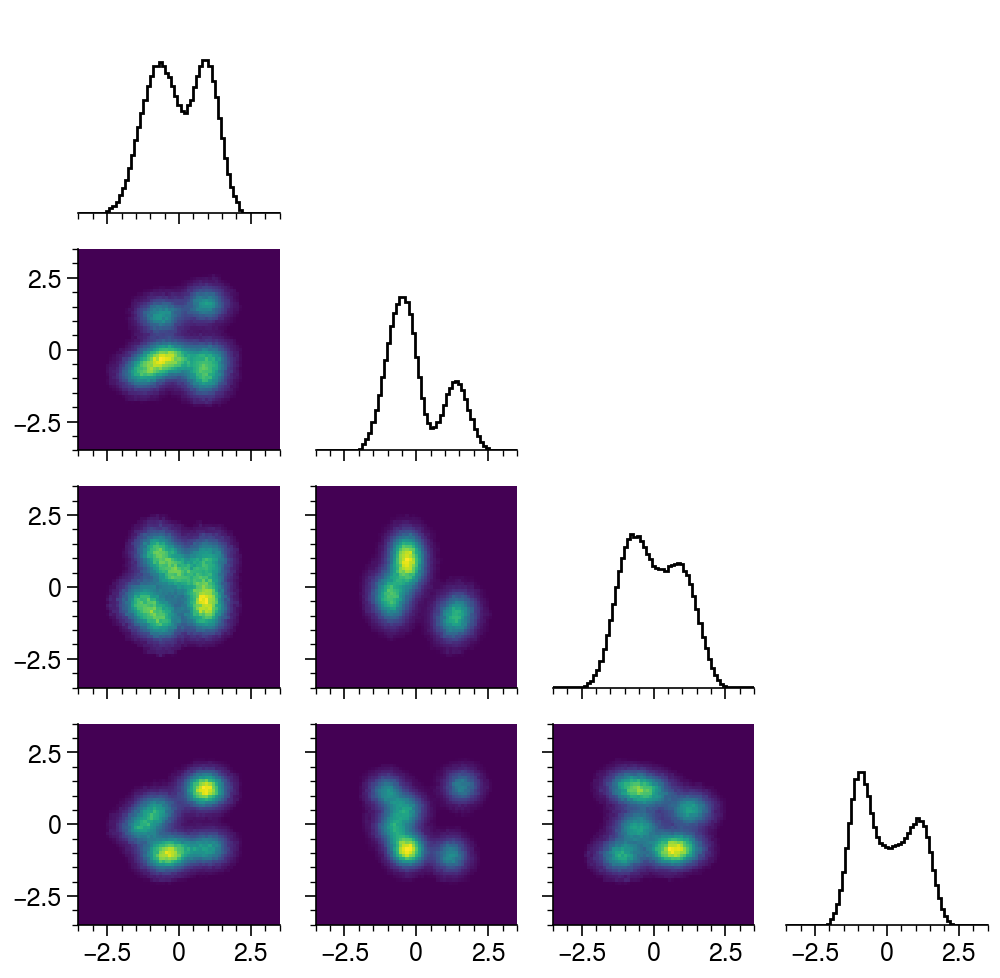

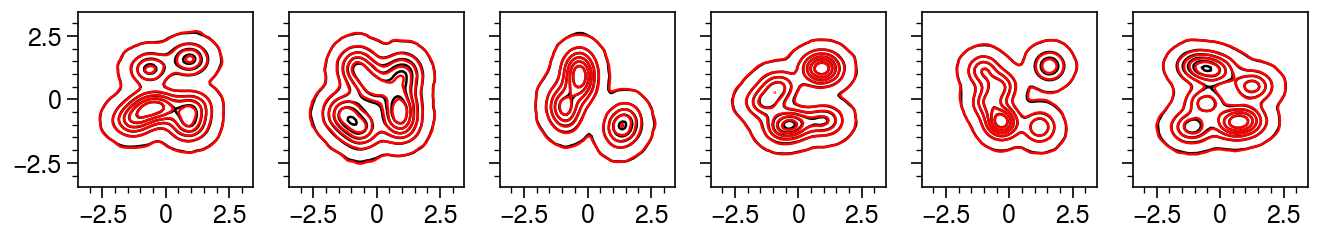

None


In [14]:
trainer = ment.train.Trainer(
    model,
    plot_func=plot_model,
    eval_func=None,
    notebook=True,
)
trainer.train(
    epochs=3,
    learning_rate=0.80,
)

## Evaluate

  0%|                                                                                                                           | 0/1499 [00:00<?, ?it/s]

 11%|████████████                                                                                                   | 163/1499 [00:00<00:00, 1627.38it/s]

 22%|████████████████████████▎                                                                                      | 328/1499 [00:00<00:00, 1638.21it/s]

 33%|████████████████████████████████████▌                                                                          | 493/1499 [00:00<00:00, 1639.69it/s]

 44%|████████████████████████████████████████████████▋                                                              | 657/1499 [00:00<00:00, 1630.72it/s]

 55%|████████████████████████████████████████████████████████████▉                                                  | 823/1499 [00:00<00:00, 1637.64it/s]

 66%|█████████████████████████████████████████████████████████████████████████                                      | 987/1499 [00:00<00:00, 1637.00it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▌                         | 1153/1499 [00:00<00:00, 1641.83it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1319/1499 [00:00<00:00, 1644.53it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1485/1499 [00:00<00:00, 1646.73it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1499/1499 [00:00<00:00, 1639.94it/s]

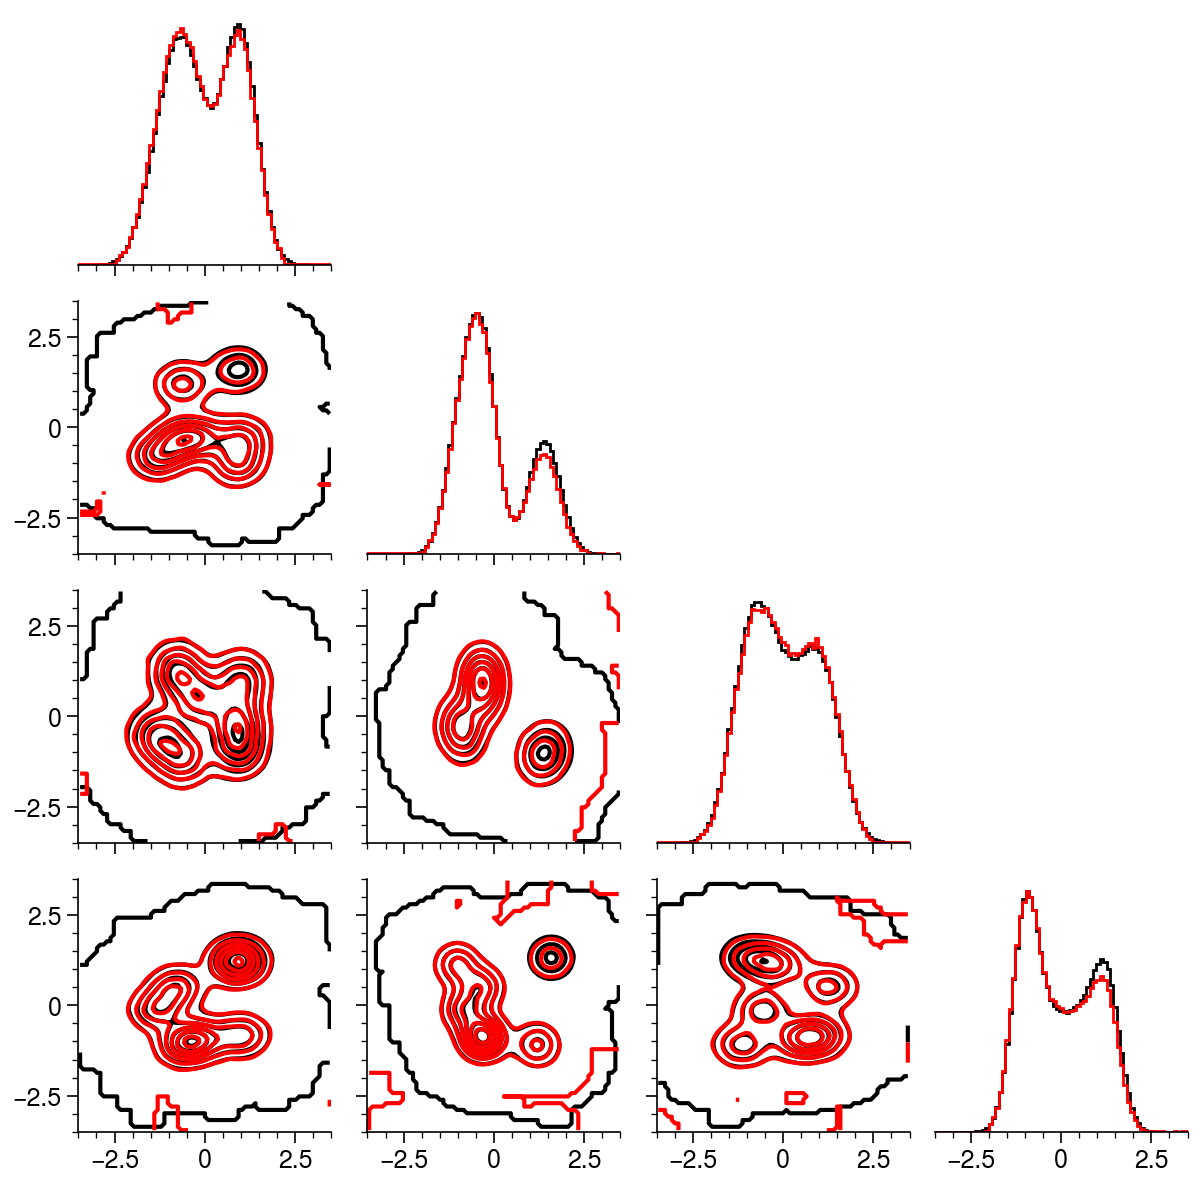

In [15]:
x_pred = model.unnormalize(model.sample(1_000_000))

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.5))
for x, color in zip([x_true, x_pred], ["black", "red"]):
    grid.plot(
        x,
        limits=limits,
        bins=75,
        diag_kws=dict(color=color),
        mask=False,
        kind="contour",
        process_kws=dict(blur=1.0),
        color=color,
        N=7,
    )
plt.show()